We import the standard Keras library

In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, Input, LSTM, Bidirectional, Conv1D
from keras.layers import Dropout, Embedding
from keras.layers import GlobalAveragePooling1D, concatenate, SpatialDropout1D
from keras.models import Model, Sequential
from keras.preprocessing import sequence, text
import matplotlib.pyplot as plt

Using TensorFlow backend.


Parameters which are being Fine - Tuned

In [2]:
num_words = 100000
maxlen = 200
batch_size = 32
epochs = 5

Data Analysis - Understanding the Training and Test Data

In [3]:
train = pd.read_csv("./data/train.csv")

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


A common preprocessing step is to check for nulls, and fill the null values with something before proceeding to the next steps. If the null values are not being handled now, it will trip you up at the modelling stage later

In [5]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

So don't need to deal with the null values. Also there is no class imbalance as we have to just output probabilities for each of the classes.

As seen, the dependent variables are in the training set itself so we need to split them up, into X and Y sets. Lets call them X_train and Y_train

In [6]:
X_train = train["comment_text"].values
Y_train = train[train.columns[2:]].values

Similarily for the Test data

In [7]:
test = pd.read_csv("./data/test.csv")

In [8]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


Check for any null in the test data

In [9]:
test.isnull().any()

id              False
comment_text    False
dtype: bool

Again, don't need to deal with the null values. Extract the X vector from the test data. Lets call it X_test

In [10]:
X_test = test["comment_text"].values

Data Wrangling 


Since our X vector consists of comments but comments are the words so we have devise an approach for feeding this into the LSTM as part of the neural network but we can't just feed the words as it is.

So this  is what we are going to do:

1.  Tokenization - We need to break down the sentence into unique words. For eg, "I love cats and love dogs" will become ["I","love","cats","and","dogs"]
2.  Indexing - We put the words in a dictionary-like structure and give them an index each For eg, {1:"I",2:"love",3:"cats",4:"and",5:"dogs"}
3.  Index Representation- We could represent the sequence of words in the comments in the form of index, and feed this chain       of index into our LSTM. For eg, [1,2,3,4,2,5]


Fortunately, Keras has made our lives so much easier. In Keras, all the above steps can be done in 4 lines of code. Note that we have to define the number of unique words in our dictionary when tokenizing the sentences. Thats the parameter we have to fine tune for optimizing the model performance. Just on the top view taking very less words in the dictionary accounts for loss in the training information. And taking very large accounts for increasing the time it takes to trainthe model.


But there's still 1 problem! What if some comments are terribly long, while some are just 1 word? So our indexed-sentence look like this:

Comment #1: [8,9,3,7,3,6,3,6,3,6,2,3,4,9]

Comment #2: [1,2]

And we have to feed a stream of data that has a consistent length(fixed number of features).

And this is why we use "padding"! We could make the shorter sentences as long as the others by filling the shortfall by zeros.But on the other hand, we also have to trim the longer ones to the same length(maxlen) as the short ones. In this case, we have set the max length to be 200.

In [11]:
X = np.concatenate((X_train, X_test), axis=0)
tokenizer = text.Tokenizer(num_words)
tokenizer.fit_on_texts(X)
X_train_l = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(X_train_l, maxlen=maxlen)
X_test_l = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(X_test_l, maxlen=maxlen)

But, how do we know that this is the best "maxlen" to set? If we put it too short, you might lose some useful feature that could cost you some accuracy points down the path.If you put it too long, your LSTM cell will have to be larger to store the possible values or states.

One of the ways to go about it is to see the distribution of the number of words in sentences.

In [12]:
t_words = [len(com) for com in X_train_l]

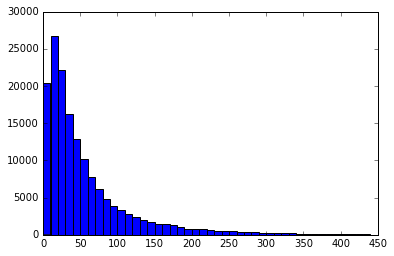

In [13]:
plt.hist(t_words,bins = np.arange(0,450,10))
plt.show()

As we can see, most of the sentence length comes under 200. So to be on the safer side we set the "maxlen" to 200, but yes we can play around these things  lets say one can also take 150 as I have read in many of the kernels.

Deep Learning Model

This is the architecture of the model being build.


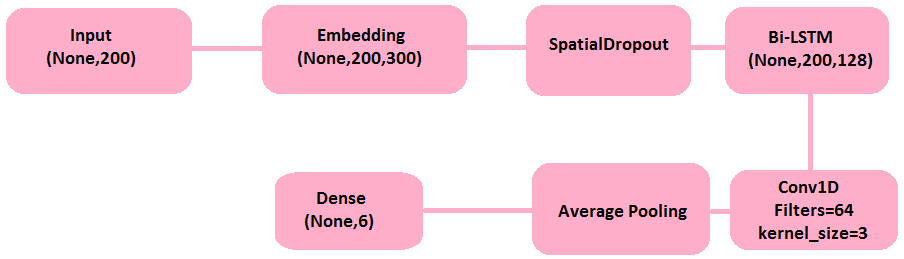

In [14]:
from IPython.display import Image
Image("diagrams/block1.png")

After having generated the input sequance of length "maxlen" Next we pass it to the Embedding layer, where we project the words to a defined vector space depending on the distance of the surrounding words in a sentence. Embedding allows us to reduce model size and most importantly the huge dimensions we have to deal with, in the case of using one-hot encoding to represent the words in our sentence.

So here the word embeddings are used that of the baseline model rather than pretrained word2vec or Glove or Fasttext or Wikipedia Embeddings, since  these pretrained embeddings are not trained against text in the same context so the number of common words between our text and text that these pretrained embeddings were trained would be low more detailed explanation can be found on this https://www.kaggle.com/sbongo/do-pretrained-embeddings-give-you-the-extra-edge

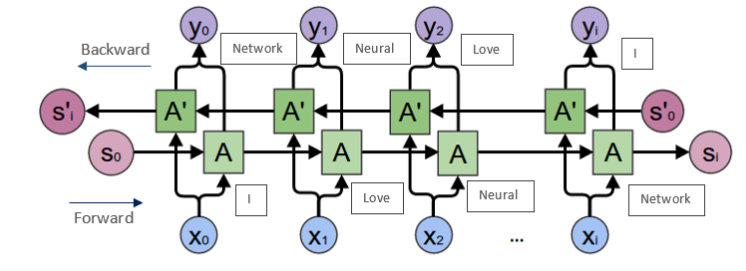

In [15]:
from IPython.display import Image
Image("diagrams/bilstm.PNG")

So why Bi-LSTM ?? 

The greatest advantage in using Bidirectional LSTM is that when it runs backwards you preserve information from the future and using the two hidden states combined, you are able in any point in time to preserve information from both past and future.

2 more new mechanisms are also introduced : LSTM Drop out and recurrent drop out.
Since these LSTM start to overfit very easily we have to use drop-out to avoid the overfitting problem but whats these two mechanisms are ??



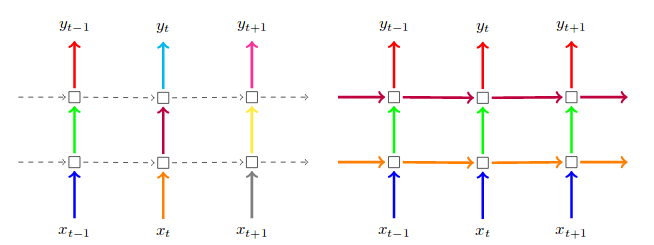

In [16]:
from IPython.display import Image
Image("diagrams/drop.PNG")

LSTM Dropout is a probabilistic drop out layer on the inputs in each time step, as depict on the left diagram(arrows pointing upwards). On the other hand, recurrent drop out is something like a dropout mask that applies drop out between the hidden states throughout the recursion of the whole LSTM network, which is depicted on the right diagram(arrows pointing to the right).

These mechanisms could be set via the "dropout" and "recurrent_dropout" parameters respectively. Please ignore the colors in the picture.

Parameters batch_size and epochs can always be play around for fine tuning the model performance, 5% data is used as a validation dataset

Also the embedding size is another parameter which can effect the model performance so to make the model robust for this embedding size we have introduced a dropout just before the Bi-LSTM and in fact use spatial Dropout as it has the lowest classification error.

As it is well known that Convolutional neural networks excel at learning the spatial structure in input data. So after the sequences are learned by LSTM which establish the relationship between the various words of sequences it is now only remains to extract the spatial information from 1d CNN to extract the features for the classification and finally the sigmoid is used to ouput the probabilities for each of these classifications.

Average pooling has an obvious advantage here as comapred to max-pooling since average retains the information for classification of each type but max just retains most of the information as to which class is most likely to occur. Another advantage of using Pooling is to make this location invariant.

In [17]:
inp = Input(shape=(maxlen,))

x = Embedding(num_words, 300)(inp)
x = SpatialDropout1D(0.35)(x)

x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)
x = Conv1D(64, kernel_size=3, padding='valid', kernel_initializer='glorot_uniform')(x)

avg_pool = GlobalAveragePooling1D()(x)

out = Dense(6, activation='sigmoid')(avg_pool)

model = Model(inp, out)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [18]:
model.fit(X_train, Y_train, batch_size=batch_size, epochs=1, validation_split=0.05)

Train on 151592 samples, validate on 7979 samples
Epoch 1/1
151592/151592 [==============================] - 5184s 34ms/step - loss: 0.0636 - acc: 0.9789 - val_loss: 0.0511 - val_acc: 0.9813


In [19]:
predictions = model.predict(X_test)

Saving the prediction in sample_submission format

In [20]:
test_ids = test["id"].values.reshape((test.shape[0], 1))
results = pd.DataFrame(np.concatenate((test_ids, predictions), axis=1), 
                       columns=["id", "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"])
results.to_csv("results2.csv", index=False)